In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('SE5.csv')
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values(by='Time', ascending=True)

## Training 1 fold

In [ ]:
# train_df = df[df["Time"] < "2020-01-01"]
# valid_df = df[(df["Time"] >= "2020-01-01") & (df["Time"] < "2024-01-01")]
# test_df = df[df["Time"] >= "2024-01-01"]
# train_df.shape, valid_df.shape, test_df.shape

In [ ]:
# x_tr, y_tr = train_df.drop(columns=['Time','class']), train_df['class']
# x_va, y_va = valid_df.drop(columns=['Time','class']), valid_df['class']
# x_ts, y_ts = test_df.drop(columns=['Time','class']), test_df['class']

In [ ]:
# params = {
#     "learning_rate": [0.005, 0.01, 0.03, 0.05, 0.1],  # low LR due to drift & overfitting risk
#     "max_depth": [-1, 3, 5, 7, 9, 12],               # -1 = no limit, try both shallow and deep
#     "min_child_samples": [5, 10, 20, 50, 100],       # regularization via minimum samples in leaf
#     "num_leaves": [7, 15, 31, 63, 127],              # should be 2^depth or smaller; more leaves = higher complexity
#     "reg_alpha": [0.0, 0.1, 0.5, 1.0, 5.0],          # L1 regularization (sparsity control)
#     "reg_lambda": [0.0, 0.1, 0.5, 1.0, 5.0],         # L2 regularization
#     "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],          # row sampling, useful for generalization
# }

# model = lgb.LGBMClassifier(objective="binary", random_state=1, n_estimators=10000, class_weight='balanced')

# search = RandomizedSearchCV(
#     estimator=model,
#     cv=3,
#     n_iter=50,
#     param_distributions=params,
#     random_state=1,
#     scoring="average_precision",
#     n_jobs=-1,
#     verbose=2,
# )

# search.fit(
#     x_tr,
#     y_tr,
#     eval_set=[(x_va, y_va)],
#     eval_metric="binary_logloss",
#     callbacks=[
#         lgb.early_stopping(stopping_rounds=20),
#         lgb.log_evaluation(period=1),
#     ],
# )

# best_model = search.best_estimator_
# # pred = best_model.predict(x_va)

# # prec = precision_score(y_va, pred)
# # recall = recall_score(y_va, pred)
# # f1 = f1_score(y_va, pred)
# # cm = confusion_matrix(y_va, pred)

# # print(prec, recall, f1)
# # print(cm)
# # print(best_model.get_params())

In [ ]:
# threshold = 0.328

In [ ]:
train_val_df = df[df["Time"] < "2024-01-01"]
test_df = df[df["Time"] >= "2024-01-01"]
X = train_val_df.drop(columns=['class'])
y = train_val_df['class']
x_ts = test_df.drop(columns='class') # Time column included
y_ts = test_df['class']
train_val_df.shape, test_df.shape

In [ ]:
def calculate_stability_score(y_true, pred, class1_proportion):
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    if fp == 0:
        return 1e9 if tp > 0 else 0.0
    if class1_proportion == 0:
        return 0.0
    stability = (tp / fp) / class1_proportion
    return stability

In [ ]:
def find_optimal_threshold(y_true, y_pred_proba, class1_proportion_val, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.3, 0.65, 100)
        
    thresholds = [t for t in thresholds if 0.001 < t < 0.999]

    results = []
    for threshold in thresholds:
        y_pred_binary = (y_pred_proba >= threshold).astype(int)
        precision = precision_score(y_true, y_pred_binary, zero_division=0)
        recall = recall_score(y_true, y_pred_binary, zero_division=0)
        f1 = f1_score(y_true, y_pred_binary, zero_division=0)
        stability = calculate_stability_score(y_true, y_pred_binary, class1_proportion_val)
        
        results.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'stability_score': stability
        })
    
    results_df = pd.DataFrame(results)
    
    if results_df.empty:
        return None, None, None, None, None

    max_stability = results_df['stability_score'].max()
    optimal_candidates = results_df[results_df['stability_score'] == max_stability]

    if optimal_candidates.empty:
        return None, None, None, None, None

    optimal_row = optimal_candidates.loc[optimal_candidates['f1_score'].idxmax()]
    
    return optimal_row['threshold'], optimal_row['precision'], optimal_row['recall'], optimal_row['f1_score'], optimal_row['stability_score']

In [ ]:
tscv = TimeSeriesSplit(n_splits=20)

precision_list = list()
recall_list = list()
f1_list = list()
stability_list = list()
conf_matrix_list = list()
train_period_list = list()
valid_period_list = list()

for i, (train_idx, val_idx) in enumerate(tscv.split(X, y)):
    x_tr, x_va = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]

    train_start = x_tr["Time"].min().strftime('%Y-%m')
    train_end = x_tr["Time"].max().strftime('%Y-%m')
    val_start = x_va["Time"].min().strftime('%Y-%m')
    val_end = x_va["Time"].max().strftime('%Y-%m')
    print(f" Fold {i + 1}, Train Period:{train_start} - {train_end}, Validation Period:{val_start} - {val_end}")

    train_period_list.append(train_start + ' - ' + train_end)
    valid_period_list.append(val_start + ' - ' + val_end)

    x_tr_nt = x_tr.drop(columns='Time') # _nt : No Time (column 'Time' dropped)
    x_va_nt = x_va.drop(columns='Time')

    # Initial model for feature selection
    tmp_model = lgb.LGBMClassifier(class_weight='balanced', objective='binary', random_state=1, learning_rate= 0.01, verbosity=-1)
    tmp_model.fit(x_tr_nt, y_tr)
    explainer = shap.TreeExplainer(tmp_model)
    shap_values = explainer.shap_values(x_tr_nt)

    features_shap = pd.DataFrame(
    {
        'Feature' : x_tr_nt.columns,
        'Importance' : np.abs(shap_values).mean(axis=0)
    }
    ).sort_values(by='Importance', ascending=False)
    q = features_shap['Importance'].quantile(0.90)
    top_features = list(features_shap[features_shap['Importance']>=q].Feature.values)

    x_tr_nt = x_tr_nt[top_features]
    x_va_nt = x_va_nt[top_features]

    # Train the main model
    lgb_params = {
        "objective": "binary",
        "class_weight": "balanced",
        "random_state": 1,
        "boosting_type": "gbdt",
        "colsample_bytree": 1.0,
        "importance_type": "gain",
        "learning_rate": 0.01,
        "max_depth": -1,
        "min_child_samples": 20,
        "min_child_weight": 0.001,
        "min_split_gain": 0.0,
        "n_estimators": 10000,
        "n_jobs": -1,
        "num_leaves": 31,
        "reg_alpha": 0.5,
        "reg_lambda": 1.0,
        "subsample": 0.9,
        "subsample_for_bin": 200000,
        "subsample_freq": 0,
    }

    lgb_model = lgb.LGBMClassifier(**lgb_params)
    lgb_model.fit(x_tr_nt, y_tr,
        eval_set=[(x_va_nt, y_va)],
        eval_metric="binary_logloss",
        callbacks=[lgb.early_stopping(stopping_rounds=20), ])  #lgb.log_evaluation(period=10)
    
    prob = lgb_model.predict_proba(x_va_nt)[:, 1]

    class1_ratio = y_va.value_counts(normalize=True)[1] # profitable trades / total trades (from validation set)
    optimal_threshold, p, r, f, stability = find_optimal_threshold(y_true=y_va, y_pred_proba=prob, class1_proportion_val=class1_ratio)
    pred_lgb = (prob > optimal_threshold).astype(int)

    cm = confusion_matrix(y_va, pred_lgb)
    
    lr_model = LogisticRegression(max_iter=1000, random_state=1, class_weight='balanced')
    lr_model.fit(x_tr_nt, y_tr)

    
    precision_list.append(p)
    recall_list.append(r)
    f1_list.append(f)
    stability_list.append(stability)
    conf_matrix_list.append(cm)

In [15]:
cv_results_df = pd.DataFrame(
    {
        "Train Period" : train_period_list,
        "Valid Period" : valid_period_list,
        "Precision" : precision_list,
        "Recall": recall_list,
        'F1': f1_list,
        "Stability": stability_list
    }
)
cv_results_df

,Train Period,Valid Period,Precision,Recall,F1,Stability
0,2008-01 - 2008-09,2008-09 - 2009-05,0.250986,0.419780,0.314145,1.433144
1,2008-01 - 2009-05,2009-05 - 2010-02,0.236504,0.329749,0.275449,2.160578
2,2008-01 - 2010-02,2010-02 - 2010-09,0.264273,0.993363,0.417480,1.546467
3,2008-01 - 2010-09,2010-09 - 2011-04,0.190361,0.251592,0.216735,1.457139
4,2008-01 - 2011-04,2011-04 - 2011-11,0.275148,0.366864,0.314455,1.456974
5,2008-01 - 2011-11,2011-11 - 2012-07,0.254401,0.624190,0.361476,1.434090
6,2008-01 - 2012-07,2012-07 - 2013-06,0.141176,0.041522,0.064171,1.106887
7,2008-01 - 2013-06,2013-06 - 2014-06,0.309353,0.140984,0.193694,2.857855
8,2008-01 - 2014-06,2014-06 - 2015-03,0.764706,0.084691,0.152493,10.300489
9,2008-01 - 2015-03,2015-03 - 2016-01,0.219822,0.450521,0.295474,1.427872


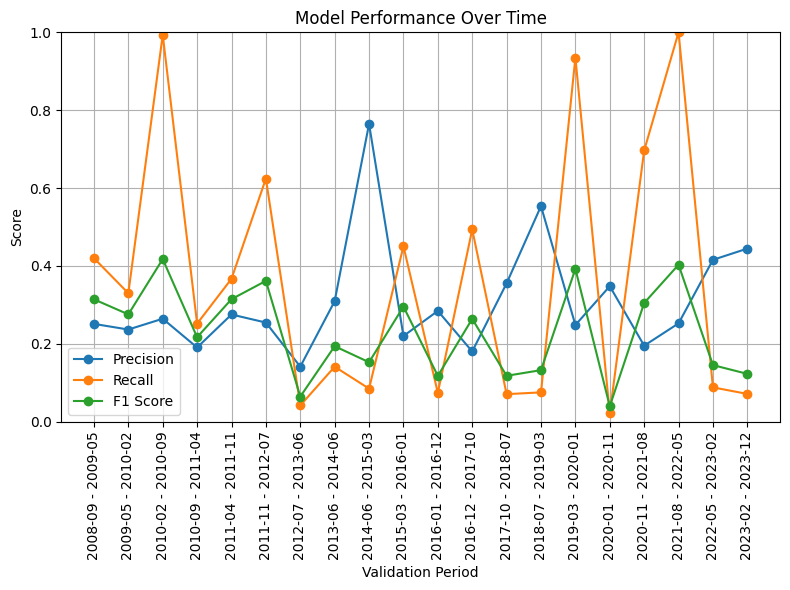

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(cv_results_df["Valid Period"], cv_results_df["Precision"], marker='o', label="Precision")
plt.plot(cv_results_df["Valid Period"], cv_results_df["Recall"], marker='o', label="Recall")
plt.plot(cv_results_df["Valid Period"], cv_results_df["F1"], marker='o', label="F1 Score")
# plt.plot(cv_results_df["Valid Period"], cv_results_df["Stability"], marker='o', label="Stability")

plt.xlabel("Validation Period")
plt.ylabel("Score")
plt.title("Model Performance Over Time")
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
train = train_val_df[(train_val_df['Time']>='2018-02-01') & (train_val_df['Time']<='2022-08-31')]
valid = train_val_df[(train_val_df['Time']>='2022-09-01') & (train_val_df['Time']<='2023-12-31')]

x_train, y_train = train.drop(columns=['Time','class']), train['class']
x_valid, y_valid = valid.drop(columns=['Time','class']), valid['class']

In [19]:
# Testing on unseen data

start_date = "2024-01-01"
end_date = "2024-03-31"

test = test_df[(test_df['Time']>=start_date) & (test_df['Time']<=end_date)]

x_ts = test.drop(columns=['Time', 'class'])
y_ts = test['class']

tmp = lgb.LGBMClassifier(class_weight='balanced', objective='binary', random_state=1, learning_rate= 0.01, verbosity=-1)
tmp.fit(x_train, y_train)
explainer = shap.TreeExplainer(tmp)
shap_values = explainer.shap_values(x_train)

features_shap = pd.DataFrame(
{
    'Feature' : x_train.columns,
    'Importance' : np.abs(shap_values).mean(axis=0)
}
).sort_values(by='Importance', ascending=False)
q = features_shap['Importance'].quantile(0.90)
top_features = list(features_shap[features_shap['Importance']>=q].Feature.values)

x_train = x_train[top_features]
x_valid = x_valid[top_features]

model = lgb.LGBMClassifier(**lgb_params)
model.fit(
    x_train, y_train,
    eval_set=[(x_valid, y_valid)],
    eval_metric="binary_logloss",
    callbacks=[lgb.early_stopping(stopping_rounds=20)])

prob = model.predict_proba(x_ts[top_features])[:, 1]

# for t in np.arange(0.2, 0.60, 0.01):
#         pred = (prob > t).astype(int)
#         print(f'{t:.2f}, {precision_score(y_ts, pred, zero_division=0):.4f}, {recall_score(y_ts, pred, zero_division=0):.4f}, {f1_score(y_ts, pred, zero_division=0):.4f}')

class1_ratio = y_ts.value_counts(normalize=True)[1]
optimal_threshold, p, r, f, stability = find_optimal_threshold(y_true=y_ts, y_pred_proba=prob, class1_proportion_val=class1_ratio)
pred = (prob >= optimal_threshold).astype(int)
cm = confusion_matrix(y_ts, pred)

print(optimal_threshold, p, r, f, stability, cm)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[208]	valid_0's binary_logloss: 0.647245
0.5404040404040404 0.34545454545454546 0.25675675675675674 0.29457364341085274 4.357732732732733 [[501  36]
 [ 55  19]]
